# EOS 1 image analysis Python code walk-through

- This is to explain how the image analysis works for the EOS 1. Python version 2.7.15 (Anaconda 64-bit)

- If you are using EOS 1, you can use this code for image analysis after reading through this notebook and understand how it works.

- Alternatively, you can also use the ImgAna_minimum.py script. 

- Needless to say, this Python code is not optimized for speed. 

- Feel free to share and modify.

## - 00 - import libraries: matplolib for handling images; numpy for matrix manipulation

In [1]:
import matplotlib.pyplot as pp
import numpy as np
import warnings

## - 01 - function for displaying images and making figures

In [2]:
# Input: x_img=numpy_array_of_image, marker=marker_of_1D_plot, x_max=max_value
def fig_out( x_img, fig_dpi=200, marker="k.-", x_max=510 ):
    pp.figure( dpi=fig_dpi )
    pp.style.use( "seaborn-dark" )
    if x_img.ndim == 1:
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( x_img, marker )
    elif x_img.ndim == 2:
        if len( x_img[0] ) == 3:
            pp.style.use( "seaborn-darkgrid" )
            pp.plot( x_img[:,0], 'r-' )
            pp.plot( x_img[:,1], 'g-' )
            pp.plot( x_img[:,2], 'b-' )
        else:
            pp.imshow( x_img, cmap="gray", vmin=0, vmax=x_max )
            pp.colorbar()
    elif x_img.ndim == 3:
        x_img = x_img.astype( int )
        pp.imshow( x_img )
    else:
        print "Input not recognized."
        ## Not raise an error because no other functions not depend on output of this function.

In Python, an image is represented by a 3D-numpy array.
For example, a simple image of:
red, green, blue, black
cyan, purple, yellow, white
can be written as the following:

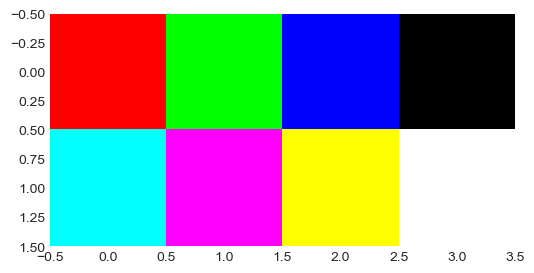

In [3]:
x = np.array([[[255,0,0], [0,255,0], [0,0,255], [0,0,0]],
              [[0,255,255], [255,0,255], [255,255,0], [255,255,255]]])
fig_out( x, fig_dpi=100 )

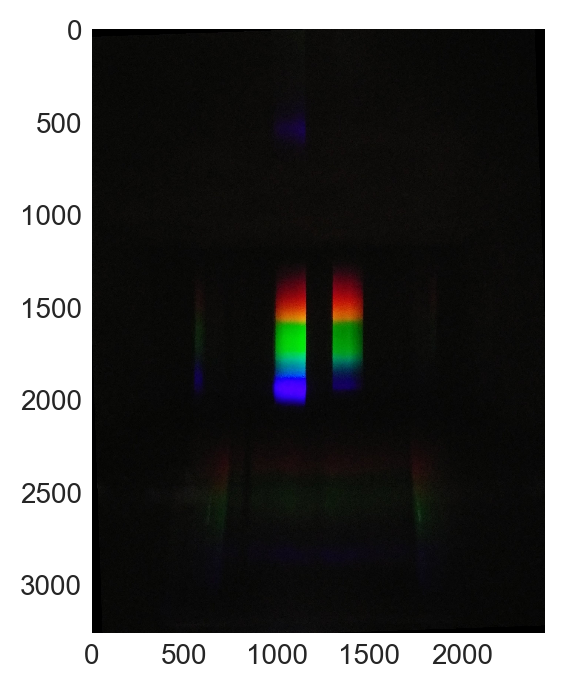

In [4]:
# example of an image from EOS 1
img_file = "EOS_imgs/example_spec.jpg"
xi = pp.imread( img_file )
fig_out( xi )

## - 02 - function for read in image and then calculating the color_diff_sum heat map

In [5]:
# Input: x_img=input_image_as_numpy_array, fo=full_output
def cal_heatmap( x_img, fo=False ):
    xf = x_img.astype( float )
    if xf.ndim == 2:
        cds  = abs(xf[:,0]-xf[:,1]) 
        cds += abs(xf[:,0]-xf[:,2]) 
        cds += abs(xf[:,1]-xf[:,2])
    elif xf.ndim == 3:
        cds  = abs(xf[:,:,0]-xf[:,:,1]) 
        cds += abs(xf[:,:,0]-xf[:,:,2]) 
        cds += abs(xf[:,:,1]-xf[:,:,2])
    else:
        raise ValueError( "Image array not recoginzed." ) 
    
    if fo == True:
        fig_out( cds )
    else:
        pass
    
    return cds

This color_diff_sum metric is used to rank the colorfulness of the pixels.
It highlights bright colors while suppresses white and black, as demonstrated below:

In [6]:
cal_heatmap( x )

array([[510., 510., 510.,   0.],
       [510., 510., 510.,   0.]])

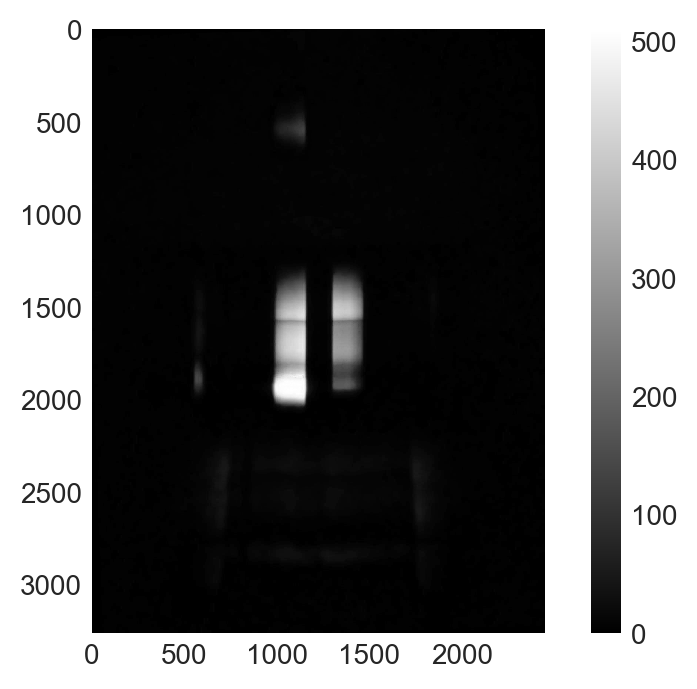

In [7]:
# try out the heat map function on the example image
hm = cal_heatmap( xi, True )

## - 03 - function for finding the reference spectrum

In [8]:
# Input: x_hm=heat_map_as_numpy_array, fo=full_output, n=threshold_as_ratio_of_peak
# Input: pf_check=profile_check, rt_check=rotation_check 
def find_ref( x_hm, fo=False, n=0.25, pf_check=True, rt_check=False ):
    n = float( n )
    if n<0.1 or n>0.9:
        n = 0.25    # n should be between 0.1 and 0.9, otherwise set to 0.25
    else:
        pass
    
    h, w = x_hm.shape
    if h<w and pf_check==True:
        warnings.warn( "Input spectra image appears to be landscape." )
        proceed = raw_input( "Continue? (y/N): " )
        if proceed=='y' or proceed=='Y':
            pass
        else:
            raise RuntimeError( "Program terminated by user." )
    else:
        pass
    
    x0 = x_hm.mean( axis=0 )
    x0thres = np.argwhere( x0 > x0.max()*n ).flatten()
    x0diff  = x0thres[1:] - x0thres[:-1]
    x0gap   = np.where( x0diff > 2. )[0].flatten()
    if len( x0gap )==0:
        if rt_check==True:
            fig_out( x_hm )
            rotate = raw_input( "Rotate image? (y/N): " )
            if rotate=='y' or rotate=='Y':
                raise RuntimeError( "Rotate image then restart program." )
            else:
                pass
        else:
            pass
        l_edge, r_edge = x0thres[0], x0thres[-1]
    else:
        d_to_center = []
        for i in x0gap:
            d_to_center.append( abs( w/2. - x0thres[i:i+2].mean() ) )
        d_min = np.argmin( d_to_center )
        if d_min==0:
            l_edge, r_edge = x0thres[0], x0thres[ x0gap[0] ]
        else:
            l_edge, r_edge = x0thres[ x0gap[d_min-1]+1 ], x0thres[ x0gap[d_min] ]
    
    x_hm_ref = x_hm[ :, l_edge:r_edge+1 ]
    x1 = x_hm_ref.mean( axis=1 )
    x1thres = np.argwhere( x1 > x1.max()*n ).flatten()
    t_edge, b_edge = x1thres[0], x1thres[-1]
    tblr_edge = ( t_edge, b_edge, l_edge, r_edge )
    
    if fo==True:
        fig_out( x0, fig_dpi=120 )
        fig_out( x1, fig_dpi=120 )
    else:
        pass
    
    return tblr_edge

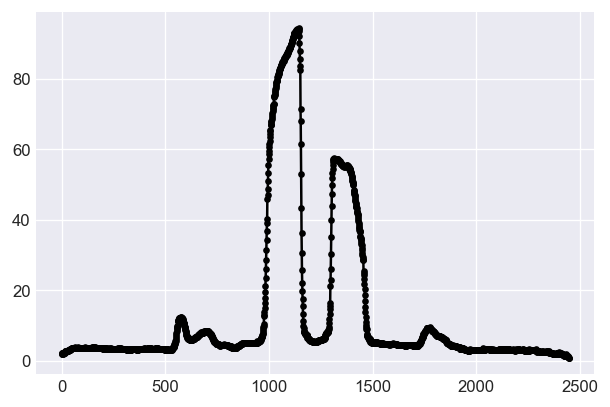

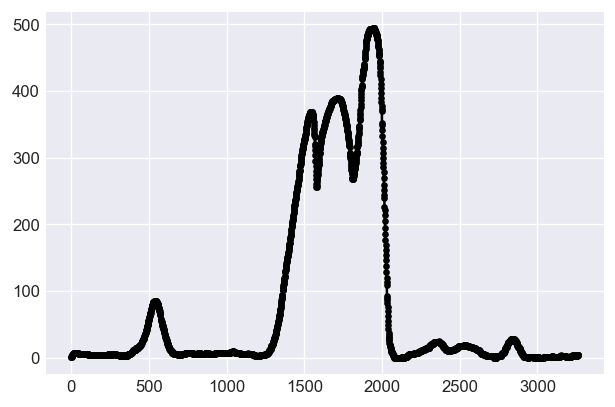

In [9]:
# try out the reference spectrum function
top, btm, lft, rgt = find_ref( hm, True )

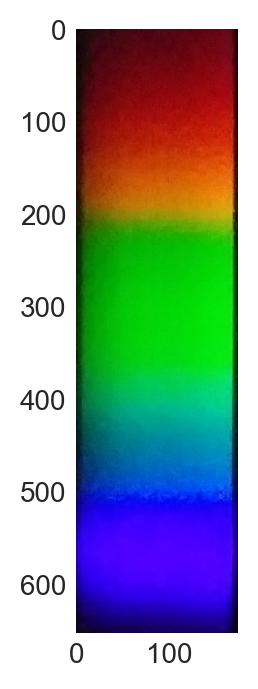

In [10]:
# check the reference spectrum found
fig_out( xi[top:btm+1, lft:rgt+1, :] )

## - 04 - function for checking the alignment (omitted) 

In [ ]:
def align_check():
    return 0

## - 05 - function for normalizing the sample spectrum 

In [11]:
# Input: x_img=input_image_as_numpy_array, fo=full_output
# Input: bpeak_chl=channel_used_to_find_blue_peak 
# Input: trim_edge=trim_edge_of_image, trim_margin=trim_margin_of_spectra
# Input: gapcal=method_for_calculating_gap_between_reference_and_sample
def norm_sam( x_img, fo=False, bpeak_chl='r', trim_edge=False, trim_margin=True, gapcal='p' ):
    h, w, d = x_img.shape 
    if trim_edge == True:
        x_img = x_img[h/4:h*3/4, w/4:w*3/4, :]
    else:
        pass
    x_img = x_img.astype( float )
    hm = cal_heatmap( x_img )
    t_edge, b_edge, l_edge, r_edge = find_ref( hm )
        
    ref_wid = r_edge - l_edge
    if trim_margin == True:
        mrg = int( ref_wid/10. )
    else:
        mrg = 0
    half_hgt = int( (b_edge - t_edge)/2. )
    x_ref = x_img[ t_edge:b_edge, l_edge+mrg:r_edge-mrg, : ]
    y_ref = x_ref.mean( axis=1 )
    
    if bpeak_chl == 'r':
        peak_r = y_ref[:half_hgt,0].argmax()
        peak_b = y_ref[half_hgt:,0].argmax()+half_hgt
    else:
        peak_rgb = y_ref.argmax( axis=0 )
        peak_r, peak_b = peak_rgb[[0,2]]

    if gapcal == 'w':
        gap = int( ref_wid*0.901 )
    else:
        gap = int( ( peak_b-peak_r )*0.368 )
    x_sam = x_img[ t_edge:b_edge, r_edge+gap+mrg:r_edge+gap+ref_wid-mrg, : ]
    y_sam = x_sam.mean( axis=1 )
    max_rgb = y_ref.max( axis=0 )

    peak_px = np.array([peak_r, peak_b]).flatten()
    peak_nm = np.array([610.65, 449.1])
    f = np.polyfit( peak_px, peak_nm, 1 )
    wavelength = np.arange(b_edge-t_edge)*f[0]+f[1]
    if trim_edge == True:
        t_edge, b_edge = t_edge+h/4, b_edge+h/4
        l_edge, r_edge = l_edge+w/4, r_edge+w/4
        peak_r, peak_b = peak_r+t_edge, peak_b+t_edge
    else:
        pass
    
    y_sam_norm_r = y_sam[:, 0]/max_rgb[0]
    y_sam_norm_g = y_sam[:, 1]/max_rgb[1]
    y_sam_norm_b = y_sam[:, 2]/max_rgb[2]
    y_sam_norm = np.dstack((y_sam_norm_r, y_sam_norm_g, y_sam_norm_b))[0]

    if fo == True:
        return ((wavelength, y_sam_norm), (y_ref, y_sam), 
                (t_edge, b_edge, l_edge, r_edge, peak_r, peak_b, gapcal))
    else:
        return (wavelength, y_sam_norm)

In [12]:
# try out the sample spectrum function
full_result = norm_sam( xi, True )
wv, sam_norm = full_result[0]
ref_raw, sam_raw = full_result[1]
other_result = full_result[2]

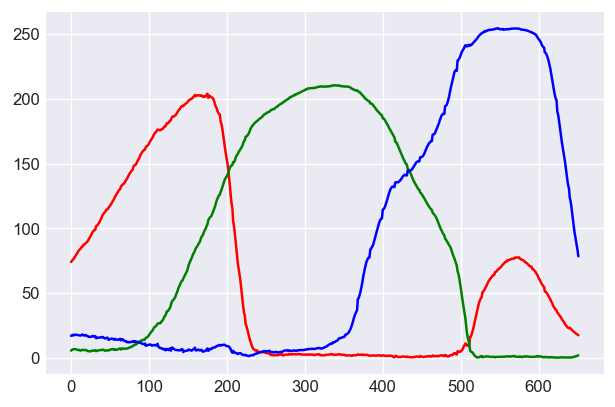

In [13]:
# check the reference spectrum (averaged)
fig_out( ref_raw, fig_dpi=120 )

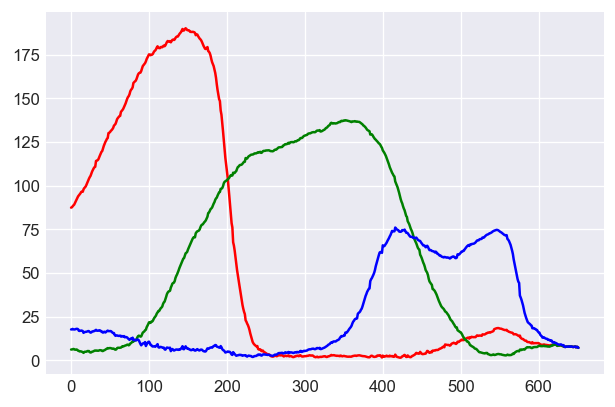

In [14]:
# check the sample spectrum (averaged) before normalization
fig_out( sam_raw, fig_dpi=120 )

Text(0,0.5,'normalized intensity')

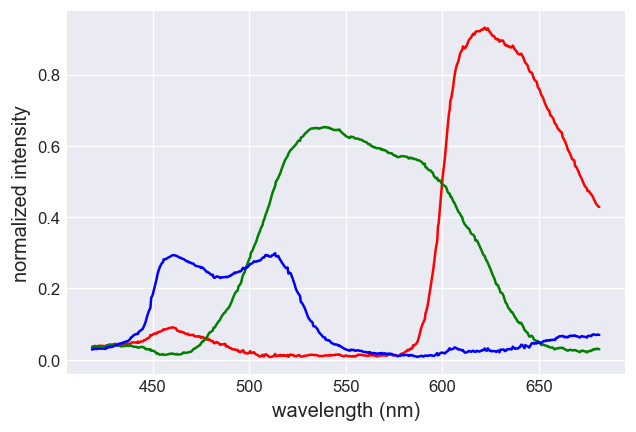

In [15]:
# check the normalized sample spectrum (averaged)
pp.figure( dpi=120 )
pp.style.use( "seaborn-darkgrid" )
pp.plot( wv, sam_norm[:,0], 'r-' )
pp.plot( wv, sam_norm[:,1], 'g-' )
pp.plot( wv, sam_norm[:,2], 'b-' )
pp.xlabel( "wavelength (nm)", size=12 )
pp.ylabel( "normalized intensity", size=12 )

## - 06 - function for calculating average intensity over a narrow band

In [16]:
# Input: ifn=image_file_name, ch=color_channel
# Input: wlc=wavelength_range_center, wlhs=wavelength_range_half_span
# Input: tm=trim_edge, gp=method_for_gap_calculation, fo=full_output
def cal_I( ifn, ch='g', wlc=535., wlhs=5., te=False, gp='p', fo=False ):
    wl_low, wl_high = wlc-wlhs, wlc+wlhs
    xi = pp.imread( ifn )
    wl_arr, sam_norm = norm_sam( xi, trim_edge=te, gapcal=gp )
    
    if ch=='r' or ch=='R':
        y_arr = sam_norm[:,0]
    elif ch=='g' or ch=='G':
        y_arr = sam_norm[:,1]
    elif ch=='b' or ch=='B':
        y_arr = sam_norm[:,2]
    else:
        raise ValueError( "Color channel should be 'r', 'g', or 'b'." )
    
    arg_low = np.where( wl_arr < wl_high )[0][0]
    arg_high = np.where( wl_arr > wl_low )[0][-1]
    I_sum = y_arr[arg_low:arg_high+1].sum()
    I_ave = I_sum/(arg_high-arg_low+1)
    
    if fo == True:
        print y_arr[arg_low:arg_high+1]
        pp.figure( dpi=120 )
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( wl_arr, y_arr, 'k.-' )
        pp.xlabel( "wavelength (nm)", size=12 )
        pp.ylabel( "normalized intensity", size=12 )
    else:
        pass
    return I_ave

[0.65222407 0.65171513 0.65286873 0.65252943 0.65195263 0.65140976
 0.65117226 0.65039188 0.64967937 0.64849184 0.64788111 0.64957758
 0.64950972 0.64947579 0.65042581 0.6497133  0.64866149 0.64934007
 0.64869542 0.64845791 0.64822041 0.64655787 0.64475961 0.64336851
 0.64167204]


0.6491500695551861

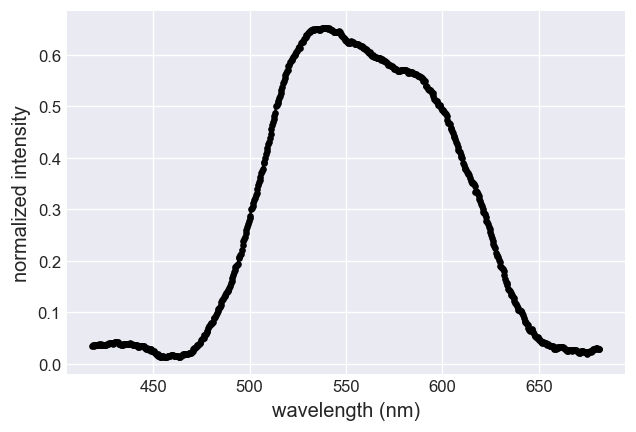

In [17]:
# try out the average intensity function
cal_I( img_file, fo=True )

## - 07 - function for calculating nitrate concentration

In [18]:
# Input: image_file=path_and_name_of_image_file, wl=center_wavelength
def test_N( image_file, wl=530., k=-7.8279, b=-0.14917 ):
    I = cal_I( img_file, wlc=wl )
    lgI = np.log10(I)
    nc = lgI*k + b
    print "Nitrate Concentration: "+str(round(nc, 2))+" mg/L"
    return nc

In [19]:
# try out the nitrate concentration function
test_N( img_file )

Nitrate Concentration: 1.39 mg/L


1.3897158679943866

The k and b values varies a little bit with each individual EOS 1 device, so to ensure accuracy, a three-point calibration is highly recommended.

## - 08 - function for calibrating nitrate tests

In [20]:
def cali_N( img_arr, nc_arr, wl, fo=True ):
    if len(img_arr) != len(nc_arr):
        raise ValueError( "img_arr and nc_arr should have the same length." )
    else:
        pass
    nc = np.array(nc_arr)
    
    I_arr = []
    for img in img_arr:
        I_arr.append( cal_I( img, wlc=wl ) )
    I_arr = np.array( I_arr )
    lgI = np.log10( I_arr )
    
    if fo == True:
        Ab = (-1.)*lgI
        kf, bf = np.polyfit( nc, Ab, 1 )
        print kf, bf

        pp.style.use( "seaborn-darkgrid" )
        pp.figure( dpi=120 )
        pp.plot( nc, Ab, 'k.', label="Calibration Data" )
        pp.plot( nc, nc*kf+bf, 'k-', label="Linear Fit" )
        pp.xlabel( "Nitrate Concentration (mg/L)", size=12)
        pp.ylabel( "Absorbance ("+str(wl-5)+"nm $-$ "+str(wl+5)+"nm)", size=12 )
        pp.legend( loc="upper left" )
    else:
        pass
    
    k, b = np.polyfit( lgI, nc_arr, 1 )
    return ((k,b), nc, lgI)

0.1274679527450263 0.020456111510477996


((-7.827915656094371, -0.14917063027112643),
 array([ 0.,  5., 10.]),
 array([-0.00321088, -0.69228635, -1.2778904 ]))

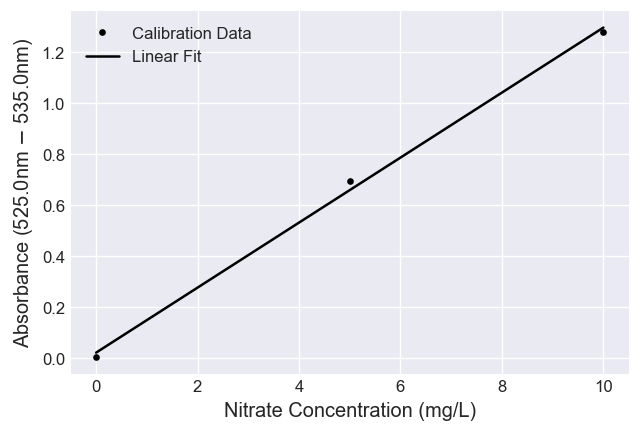

In [21]:
imgs = ["EOS_imgs//0mg.jpg", "EOS_imgs//5mg.jpg", "EOS_imgs//10mg.jpg"]
ncs = [0.0, 5.0, 10.0]
cali_N( imgs, ncs, 530. )

In [23]:
k, b = cali_N( imgs, ncs, 530., fo=False )[0]

After you run the cali_N, you will feed the k & b back into test_N as inputs.